# Backtesting de Estrategia de Opciones del S&P 500

Este notebook demuestra cómo realizar backtesting de una estrategia de opciones sobre el S&P 500 (SPY).

## Estrategia: Venta de Put Spread
- Vender un put con strike más alto
- Comprar un put con strike más bajo
- Beneficio limitado, pérdida limitada
- Rentabilidad en mercados alcistas o laterales

In [12]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 1. Descarga de Datos Históricos

In [13]:
# Definir parámetros
ticker = "SPY"  # ETF del S&P 500
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Descargar datos
print(f"Descargando datos de {ticker} desde {start_date} hasta {end_date}...")
spy = yf.Ticker(ticker)
df = spy.history(start=start_date, end=end_date)

print(f"\n✓ Datos descargados: {len(df)} registros")
print(f"\nRango de fechas: {df.index[0].strftime('%Y-%m-%d')} a {df.index[-1].strftime('%Y-%m-%d')}")
df.head()

Descargando datos de SPY desde 2020-01-01 hasta 2025-10-31...

✓ Datos descargados: 1466 registros

Rango de fechas: 2020-01-02 a 2025-10-30


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-01-02 00:00:00-05:00,297.356231,298.596982,296.427960,298.578583,59151200,0.0,0.0,0.0
2020-01-03 00:00:00-05:00,295.168971,297.448278,295.113829,296.317810,77709700,0.0,0.0,0.0
2020-01-06 00:00:00-05:00,294.553085,297.530894,294.433601,297.448181,55653900,0.0,0.0,0.0
2020-01-07 00:00:00-05:00,296.878327,297.356262,296.161453,296.611816,40496400,0.0,0.0,0.0
2020-01-08 00:00:00-05:00,296.804851,299.415010,296.556712,298.192657,68296000,0.0,0.0,0.0


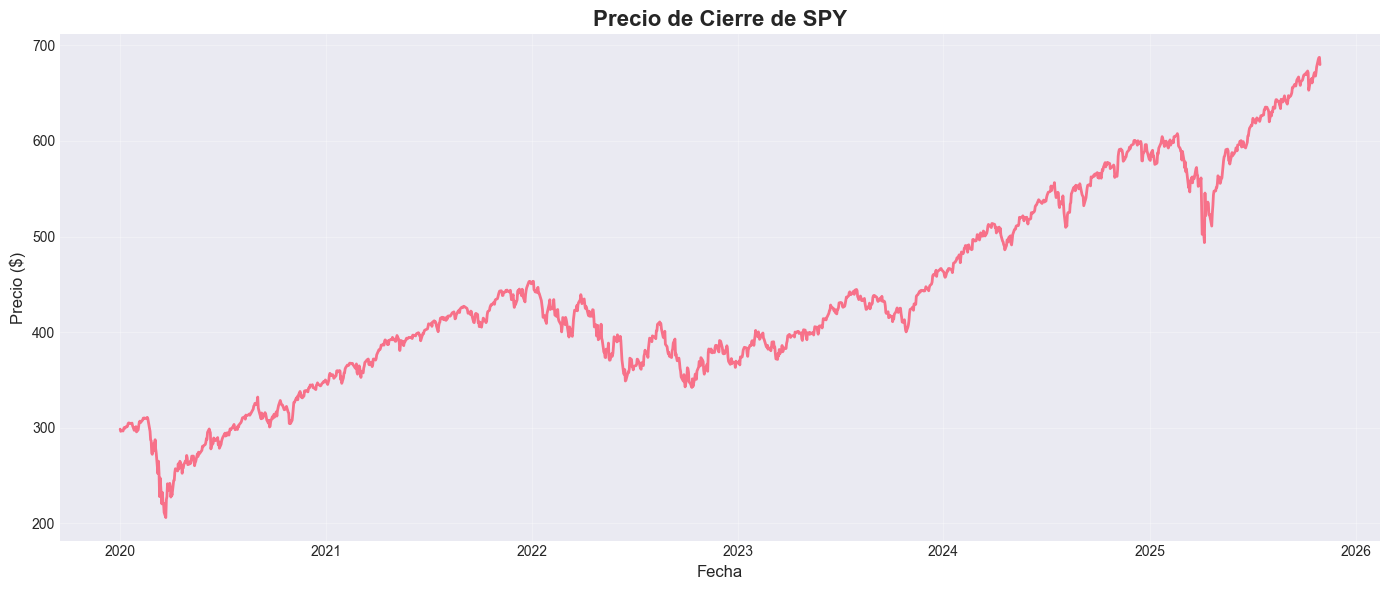


Estadísticas del Precio:
count    1466.000000
mean      435.391232
std       103.152020
min       206.111801
25%       368.803314
50%       415.302750
75%       511.650284
max       687.390015
Name: Close, dtype: float64


In [14]:
# Visualizar precio de cierre
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], linewidth=2)
plt.title(f'Precio de Cierre de {ticker}', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas básicas
print("\nEstadísticas del Precio:")
print(df['Close'].describe())

## 2. Cálculo de Indicadores Técnicos

In [15]:
# Calcular volatilidad histórica (ventana de 20 días)
df['Returns'] = df['Close'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(252) * 100

# Medias móviles
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# Eliminar NaN
df.dropna(inplace=True)

print("✓ Indicadores técnicos calculados")
df[['Close', 'Volatility', 'SMA_20', 'SMA_50', 'RSI']].tail(10)

✓ Indicadores técnicos calculados


,Close,Volatility,SMA_20,SMA_50,RSI
Date,,,,,
2025-10-17 00:00:00-04:00,664.390015,13.067267,665.062497,653.631387,50.627563
2025-10-20 00:00:00-04:00,671.299988,13.483004,665.285495,654.349020,54.198112
2025-10-21 00:00:00-04:00,671.289978,13.309245,665.689493,655.091583,52.418238
2025-10-22 00:00:00-04:00,667.799988,13.404979,666.024493,655.629320,48.844410
2025-10-23 00:00:00-04:00,671.760010,13.389968,666.709995,656.202379,51.949835
2025-10-24 00:00:00-04:00,677.250000,13.530196,667.481494,656.884042,54.118010
2025-10-27 00:00:00-04:00,685.239990,14.039647,668.559494,657.755620,60.894854
2025-10-28 00:00:00-04:00,687.059998,14.022825,669.603494,658.666392,59.713157
2025-10-29 00:00:00-04:00,687.390015,14.010763,670.550494,659.653370,61.561525


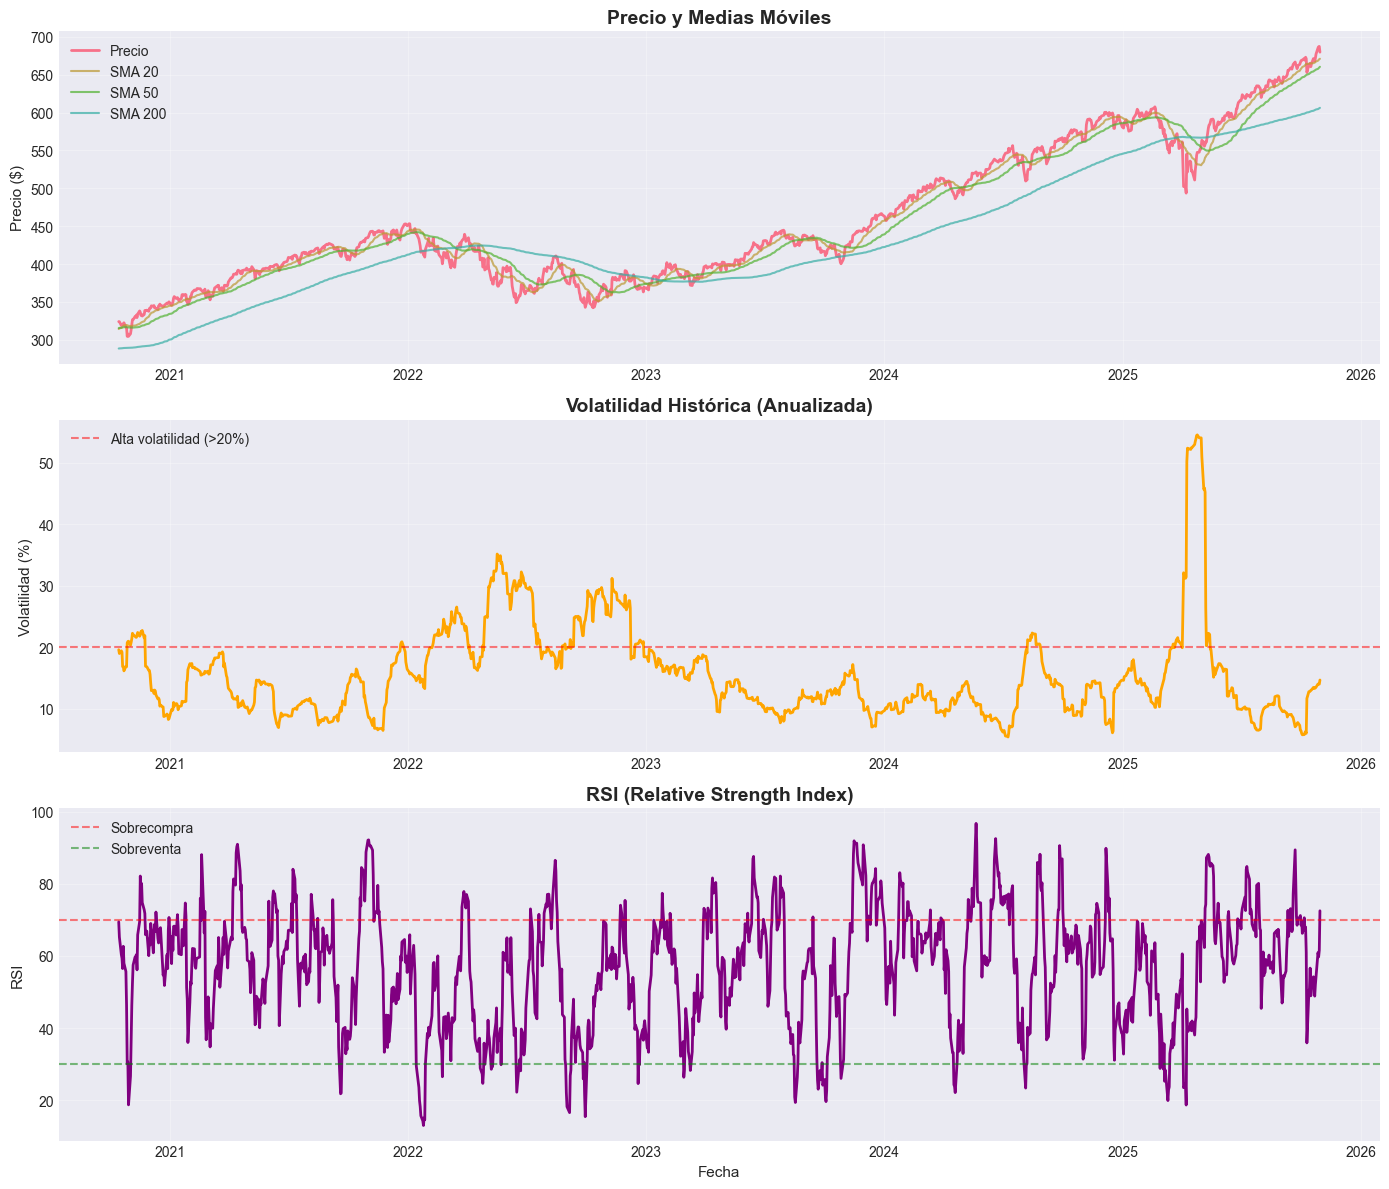

In [16]:
# Visualizar indicadores
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Precio y medias móviles
axes[0].plot(df.index, df['Close'], label='Precio', linewidth=2)
axes[0].plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7)
axes[0].plot(df.index, df['SMA_50'], label='SMA 50', alpha=0.7)
axes[0].plot(df.index, df['SMA_200'], label='SMA 200', alpha=0.7)
axes[0].set_title('Precio y Medias Móviles', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precio ($)', fontsize=11)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Volatilidad
axes[1].plot(df.index, df['Volatility'], color='orange', linewidth=2)
axes[1].axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Alta volatilidad (>20%)')
axes[1].set_title('Volatilidad Histórica (Anualizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatilidad (%)', fontsize=11)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# RSI
axes[2].plot(df.index, df['RSI'], color='purple', linewidth=2)
axes[2].axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Sobrecompra')
axes[2].axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Sobreventa')
axes[2].set_title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('RSI', fontsize=11)
axes[2].set_xlabel('Fecha', fontsize=11)
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Simulación de Estrategia: Put Credit Spread

### Reglas de la Estrategia:
1. **Entrada**: Cuando el precio está por encima de SMA 50 y RSI < 70
2. **Put Spread**: 
   - Vender put a 5% debajo del precio actual
   - Comprar put a 10% debajo del precio actual
3. **Duración**: 30 días hasta expiración
4. **Prima recibida**: ~2% del spread (simplificado)
5. **Salida**: Al vencimiento o stop loss del 50%

In [17]:
class PutCreditSpreadBacktest:
    def __init__(self, df, initial_capital=100000):
        self.df = df.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.positions = []
        self.closed_trades = []
        self.equity_curve = []
        
    def check_entry_signal(self, row):
        """Verifica si hay señal de entrada"""
        return (row['Close'] > row['SMA_50'] and 
                row['RSI'] < 70 and 
                row['RSI'] > 30)
    
    def open_position(self, date, price):
        """Abre un put credit spread"""
        short_strike = price * 0.95  # 5% OTM
        long_strike = price * 0.90   # 10% OTM
        spread_width = short_strike - long_strike
        
        # Prima recibida (simplificada al 2% del spread)
        premium = spread_width * 0.02
        
        # Número de contratos (cada contrato = 100 acciones)
        # Usar 5% del capital por trade
        max_loss = spread_width - premium
        risk_amount = self.capital * 0.05
        contracts = int(risk_amount / (max_loss * 100))
        
        if contracts > 0:
            position = {
                'entry_date': date,
                'entry_price': price,
                'short_strike': short_strike,
                'long_strike': long_strike,
                'premium': premium,
                'contracts': contracts,
                'expiration': date + timedelta(days=30),
                'max_profit': premium * contracts * 100,
                'max_loss': max_loss * contracts * 100
            }
            self.positions.append(position)
            return True
        return False
    
    def check_positions(self, date, current_price):
        """Verifica y cierra posiciones si es necesario"""
        positions_to_remove = []
        
        for i, pos in enumerate(self.positions):
            # Verificar si ha expirado
            if date >= pos['expiration']:
                # Calcular P&L al vencimiento
                if current_price > pos['short_strike']:
                    # Opciones expiran sin valor, ganamos toda la prima
                    pnl = pos['max_profit']
                elif current_price < pos['long_strike']:
                    # Pérdida máxima
                    pnl = -pos['max_loss']
                else:
                    # Pérdida parcial
                    intrinsic_value = (pos['short_strike'] - current_price) * pos['contracts'] * 100
                    pnl = pos['premium'] * pos['contracts'] * 100 - intrinsic_value
                
                self.capital += pnl
                pos['exit_date'] = date
                pos['exit_price'] = current_price
                pos['pnl'] = pnl
                pos['return_pct'] = (pnl / pos['max_loss']) * 100
                self.closed_trades.append(pos)
                positions_to_remove.append(i)
            
            # Stop loss al 50% de pérdida
            elif current_price < pos['short_strike']:
                intrinsic_value = (pos['short_strike'] - current_price) * pos['contracts'] * 100
                current_loss = intrinsic_value - pos['premium'] * pos['contracts'] * 100
                
                if current_loss > pos['max_loss'] * 0.5:
                    pnl = -current_loss
                    self.capital += pnl
                    pos['exit_date'] = date
                    pos['exit_price'] = current_price
                    pos['pnl'] = pnl
                    pos['return_pct'] = (pnl / pos['max_loss']) * 100
                    pos['stop_loss'] = True
                    self.closed_trades.append(pos)
                    positions_to_remove.append(i)
        
        # Eliminar posiciones cerradas
        for i in sorted(positions_to_remove, reverse=True):
            del self.positions[i]
    
    def run(self):
        """Ejecuta el backtest"""
        print("Ejecutando backtest...\n")
        
        for date, row in self.df.iterrows():
            # Verificar posiciones abiertas
            self.check_positions(date, row['Close'])
            
            # Buscar nuevas entradas (máximo 3 posiciones simultáneas)
            if len(self.positions) < 3 and self.check_entry_signal(row):
                self.open_position(date, row['Close'])
            
            # Guardar equity
            self.equity_curve.append({
                'date': date,
                'capital': self.capital,
                'open_positions': len(self.positions)
            })
        
        # Cerrar posiciones abiertas al final
        for pos in self.positions:
            final_price = self.df.iloc[-1]['Close']
            if final_price > pos['short_strike']:
                pnl = pos['max_profit']
            else:
                intrinsic_value = (pos['short_strike'] - final_price) * pos['contracts'] * 100
                pnl = pos['premium'] * pos['contracts'] * 100 - intrinsic_value
            
            self.capital += pnl
            pos['exit_date'] = self.df.index[-1]
            pos['exit_price'] = final_price
            pos['pnl'] = pnl
            pos['return_pct'] = (pnl / pos['max_loss']) * 100
            self.closed_trades.append(pos)
        
        self.positions = []
        
        print(f"✓ Backtest completado")
        print(f"Total de trades: {len(self.closed_trades)}")
        print(f"Capital inicial: ${self.initial_capital:,.2f}")
        print(f"Capital final: ${self.capital:,.2f}")
        print(f"Retorno total: {((self.capital - self.initial_capital) / self.initial_capital * 100):.2f}%")

# Ejecutar backtest
backtest = PutCreditSpreadBacktest(df, initial_capital=100000)
backtest.run()

Ejecutando backtest...

✓ Backtest completado
Total de trades: 147
Capital inicial: $100,000.00
Capital final: $87,201.25
Retorno total: -12.80%


## 4. Análisis de Resultados

In [18]:
# Convertir trades a DataFrame
trades_df = pd.DataFrame(backtest.closed_trades)

if len(trades_df) > 0:
    print("\n📊 ESTADÍSTICAS DE TRADING\n" + "="*50)
    
    # Métricas generales
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl'] > 0])
    losing_trades = len(trades_df[trades_df['pnl'] < 0])
    win_rate = (winning_trades / total_trades) * 100
    
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if losing_trades > 0 else 0
    
    profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / 
                       trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if losing_trades > 0 else float('inf')
    
    print(f"Total de trades: {total_trades}")
    print(f"Trades ganadores: {winning_trades} ({win_rate:.2f}%)")
    print(f"Trades perdedores: {losing_trades} ({100-win_rate:.2f}%)")
    print(f"\nGanancia promedio: ${avg_win:,.2f}")
    print(f"Pérdida promedio: ${avg_loss:,.2f}")
    print(f"\nProfit Factor: {profit_factor:.2f}")
    print(f"Máxima ganancia: ${trades_df['pnl'].max():,.2f}")
    print(f"Máxima pérdida: ${trades_df['pnl'].min():,.2f}")
    
    # Mostrar algunos trades
    print("\n📈 Últimos 10 trades:")
    display_cols = ['entry_date', 'exit_date', 'entry_price', 'short_strike', 'pnl', 'return_pct']
    print(trades_df[display_cols].tail(10).to_string(index=False))
else:
    print("No se ejecutaron trades en el período")


📊 ESTADÍSTICAS DE TRADING
Total de trades: 147
Trades ganadores: 133 (90.48%)
Trades perdedores: 14 (9.52%)

Ganancia promedio: $71.62
Pérdida promedio: $-1,594.61

Profit Factor: 0.43
Máxima ganancia: $101.71
Máxima pérdida: $-4,541.29

📈 Últimos 10 trades:
               entry_date                 exit_date  entry_price  short_strike       pnl  return_pct
2025-07-21 00:00:00-04:00 2025-08-20 00:00:00-04:00   627.031616    595.680035 62.703162    2.040816
2025-07-22 00:00:00-04:00 2025-08-21 00:00:00-04:00   627.121338    595.765271 62.712134    2.040816
2025-08-18 00:00:00-04:00 2025-09-17 00:00:00-04:00   641.521423    609.445352 64.152142    2.040816
2025-08-20 00:00:00-04:00 2025-09-19 00:00:00-04:00   636.345764    604.528476 63.634576    2.040816
2025-08-21 00:00:00-04:00 2025-09-22 00:00:00-04:00   633.792847    602.103204 63.379285    2.040816
2025-09-17 00:00:00-04:00 2025-10-17 00:00:00-04:00   657.357544    624.489667 65.735754    2.040816
2025-09-25 00:00:00-04:00 2025-10

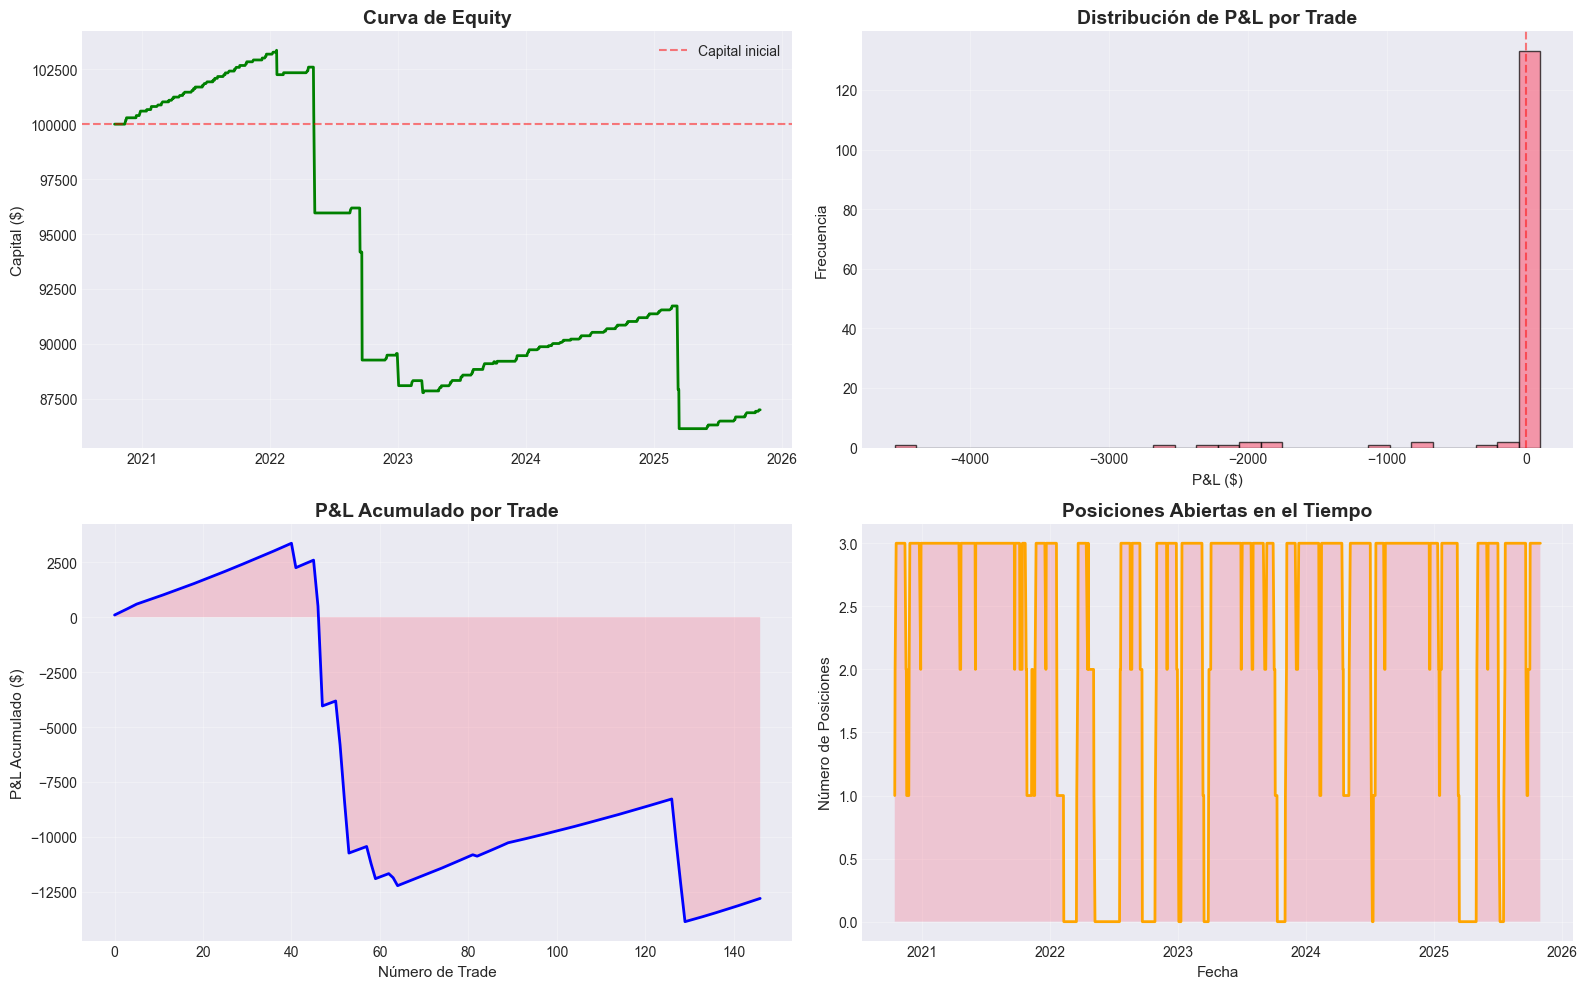

In [19]:
# Curva de equity
equity_df = pd.DataFrame(backtest.equity_curve)
equity_df.set_index('date', inplace=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Curva de equity
axes[0, 0].plot(equity_df.index, equity_df['capital'], linewidth=2, color='green')
axes[0, 0].axhline(y=backtest.initial_capital, color='red', linestyle='--', alpha=0.5, label='Capital inicial')
axes[0, 0].set_title('Curva de Equity', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Capital ($)', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de P&L
if len(trades_df) > 0:
    axes[0, 1].hist(trades_df['pnl'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Distribución de P&L por Trade', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('P&L ($)', fontsize=11)
    axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

# 3. P&L acumulado
if len(trades_df) > 0:
    trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum()
    axes[1, 0].plot(range(len(trades_df)), trades_df['cumulative_pnl'], linewidth=2, color='blue')
    axes[1, 0].fill_between(range(len(trades_df)), trades_df['cumulative_pnl'], alpha=0.3)
    axes[1, 0].set_title('P&L Acumulado por Trade', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Número de Trade', fontsize=11)
    axes[1, 0].set_ylabel('P&L Acumulado ($)', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

# 4. Posiciones abiertas en el tiempo
axes[1, 1].plot(equity_df.index, equity_df['open_positions'], linewidth=2, color='orange')
axes[1, 1].fill_between(equity_df.index, equity_df['open_positions'], alpha=0.3)
axes[1, 1].set_title('Posiciones Abiertas en el Tiempo', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Fecha', fontsize=11)
axes[1, 1].set_ylabel('Número de Posiciones', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


⚠️ MÉTRICAS DE RIESGO
Sharpe Ratio: -1.39
Máximo Drawdown: -16.66%
Volatilidad Anualizada: 4.05%


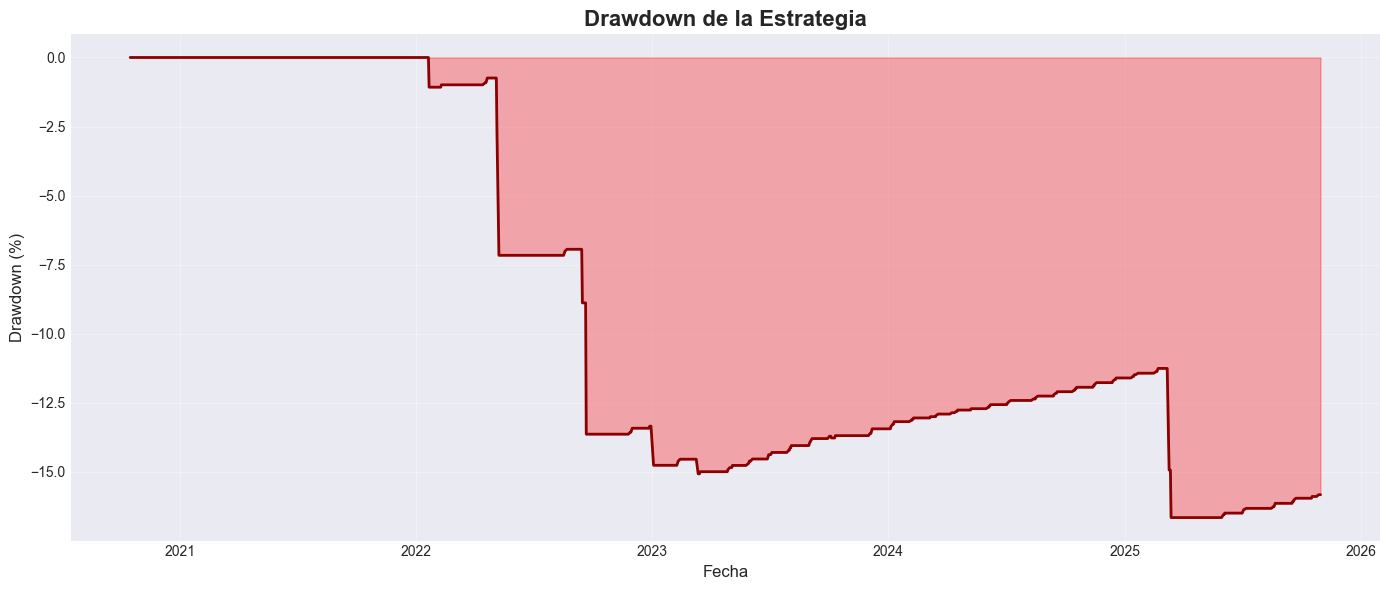

In [20]:
# Métricas de riesgo
if len(equity_df) > 0:
    equity_df['returns'] = equity_df['capital'].pct_change()
    equity_df.dropna(inplace=True)
    
    print("\n⚠️ MÉTRICAS DE RIESGO\n" + "="*50)
    
    # Sharpe Ratio (asumiendo tasa libre de riesgo del 3%)
    risk_free_rate = 0.03
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    excess_returns = equity_df['returns'] - daily_rf
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / equity_df['returns'].std()
    
    # Máximo Drawdown
    equity_df['cummax'] = equity_df['capital'].cummax()
    equity_df['drawdown'] = (equity_df['capital'] - equity_df['cummax']) / equity_df['cummax'] * 100
    max_drawdown = equity_df['drawdown'].min()
    
    # Volatilidad anualizada
    annual_volatility = equity_df['returns'].std() * np.sqrt(252) * 100
    
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Máximo Drawdown: {max_drawdown:.2f}%")
    print(f"Volatilidad Anualizada: {annual_volatility:.2f}%")
    
    # Visualizar drawdown
    plt.figure(figsize=(14, 6))
    plt.fill_between(equity_df.index, equity_df['drawdown'], 0, alpha=0.3, color='red')
    plt.plot(equity_df.index, equity_df['drawdown'], linewidth=2, color='darkred')
    plt.title('Drawdown de la Estrategia', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Análisis Mensual de Retornos

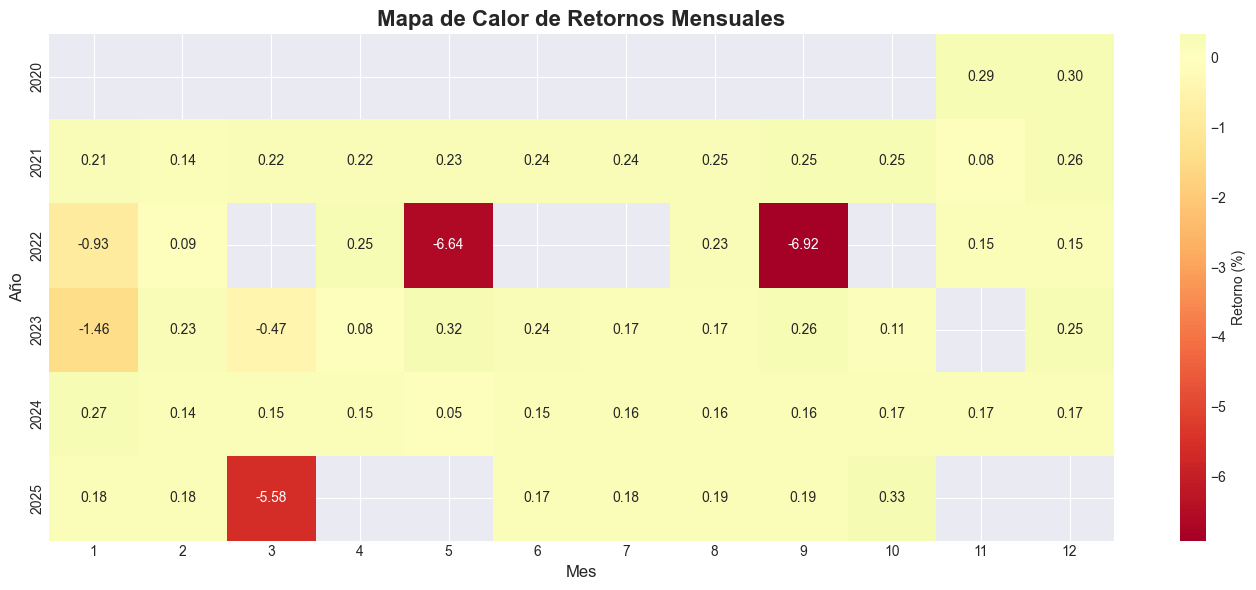


📅 RETORNOS MENSUALES
month
2020-11    0.289970
2020-12    0.304542
2021-01    0.208261
2021-02    0.140456
2021-03    0.215388
2021-04    0.220467
2021-05    0.231121
2021-06    0.236217
2021-07    0.238887
2021-08    0.247222
2021-09    0.252419
2021-10    0.252578
2021-11    0.083667
2021-12    0.264725
2022-01   -0.934603
2022-02    0.088327
2022-04    0.254760
2022-05   -6.635495
2022-08    0.225970
2022-09   -6.919733
2022-11    0.148797
2022-12    0.149796
2023-01   -1.463312
2023-02    0.228119
2023-03   -0.467716
2023-04    0.077684
2023-05    0.317964
2023-06    0.242074
2023-07    0.167783
2023-08    0.172307
2023-09    0.261453
2023-10    0.110399
2023-12    0.254875
2024-01    0.268068
2024-02    0.138894
2024-03    0.145365
2024-04    0.150300
2024-05    0.050928
2024-06    0.151693
2024-07    0.156742
2024-08    0.164103
2024-09    0.163275
2024-10    0.166090
2024-11    0.173018
2024-12    0.174982
2025-01    0.178247
2025-02    0.179137
2025-03   -5.582841
2025-06    0

In [ ]:
if len(trades_df) > 0:
    # Agregar retornos por mes
    trades_df['month'] = pd.to_datetime(trades_df['exit_date']).dt.to_period('M')
    monthly_returns = trades_df.groupby('month')['pnl'].sum()
    
    # Calcular retorno porcentual mensual
    monthly_pct = (monthly_returns / backtest.initial_capital) * 100
    
    # Crear heatmap de retornos mensuales
    monthly_df = monthly_pct.to_frame()
    monthly_df.columns = ['return']
    monthly_df['year'] = monthly_df.index.year
    monthly_df['month'] = monthly_df.index.month
    
    pivot_table = monthly_df.pivot_table(values='return', index='year', columns='month', aggfunc='sum')
    
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Retorno (%)'})
    plt.title('Mapa de Calor de Retornos Mensuales', fontsize=16, fontweight='bold')
    plt.xlabel('Mes', fontsize=12)
    plt.ylabel('Año', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\n📅 RETORNOS MENSUALES\n" + "="*50)
    print(monthly_pct.to_string())

## 6. Conclusiones

Este notebook demuestra:

1. ✅ Cómo descargar datos históricos del S&P 500
2. ✅ Cálculo de indicadores técnicos (SMA, RSI, volatilidad)
3. ✅ Implementación de una estrategia de Put Credit Spread
4. ✅ Análisis de resultados con métricas clave
5. ✅ Visualización de la curva de equity y drawdown

### Próximos Pasos:

- Optimizar parámetros de la estrategia
- Implementar más estrategias de opciones (Iron Condor, Butterfly, etc.)
- Agregar costos de transacción más realistas
- Incorporar datos reales de opciones (Greeks, IV)
- Realizar análisis de sensibilidad
- Implementar gestión de riesgo más sofisticada

In [22]:
# Guardar resultados
if len(trades_df) > 0:
    output_file = '../results/backtest_results.csv'
    trades_df.to_csv(output_file, index=False)
    print(f"\n✓ Resultados guardados en: {output_file}")


✓ Resultados guardados en: ../results/backtest_results.csv
